# Машинное обучение, ВМК МГУ

## Практическое задание 5 

### Общая информация
Дата выдачи: 7 мая 2018

Мягкий дедлайн: 23:59MSK 20 мая (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 мая.

### О задании

Мы будем решать задачу предсказания опасных событий для страховой компании: [Liberty Mutual Group: Property Inspection Prediction](https://www.kaggle.com/c/liberty-mutual-group-property-inspection-prediction). Обучающая выборка состоит из засекреченных признаков целого и строкового типов. Целевая переменная-счётчик $y \in \mathbb{Z}_+$.

Работа состоит из следующих пунктов:
* Предобработать наши данные [1 балл]
* Написать свой алгоритм прогнозирования событий [2 балла]
* Настроить линейные методы из библиотеки StatsModels для решения задачи [1 балл]
* Настроить бустинг из библиотеки lightgbm для решения задачи [1 балл]
* Проинтерпретировать полученные результаты и написать выводы [1 балл]
* Бонусы [0.5 балла]


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6.5 балла.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-05-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-05-IvanovIvan.ipynb). 

Далее отправьте этот файл на ml.cmc.msu@gmail.com

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

** Оценка:** ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize
from lightgbm import LGBMModel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_rows', 10)
pd.set_option('max_columns', None)
plt.style.use('bmh')

%matplotlib inline

__Задание 1 (1 балл).__ Загрузка и предобработка данных.

In [2]:
data = pd.read_csv('data.csv', index_col='Id')
data.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V10,T1_V11,T1_V12,T1_V13,T1_V14,T1_V15,T1_V16,T1_V17,T2_V1,T2_V2,T2_V3,T2_V4,T2_V5,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,7,B,B,15,1,A,B,N,36,11,N,10,B,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,12,B,B,10,3,A,B,Y,78,10,Y,17,C,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,12,H,B,15,1,A,R,Y,71,21,Y,13,C,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,3,H,B,15,1,A,R,N,71,13,N,15,A,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,7,H,B,10,1,A,J,N,75,10,Y,11,B,1,22,1,2,7,N,N,E,1,1


In [3]:
data.shape

(50964, 33)

Выделим категориальные и числовые признаки:

In [4]:
categorical, numerical = list(), list()
for col in data.columns[1:]:
    if isinstance(data.loc[1, col], str):
        categorical.append(col)
    if isinstance(data.loc[1, col], np.int64):
        numerical.append(col)

In [5]:
data[categorical].nunique().values

array([ 8, 10,  2,  4,  4,  6, 12,  4,  8, 18,  2,  2,  6,  2,  2,  5])

In [6]:
data[numerical].nunique().values

array([ 19,  24,   9,   5,   4,   5, 100,  39,  22,   7,   7,   3,  25,
         7,   7,  12])

Нарисуем априорное распределение ответов $p(y)$:

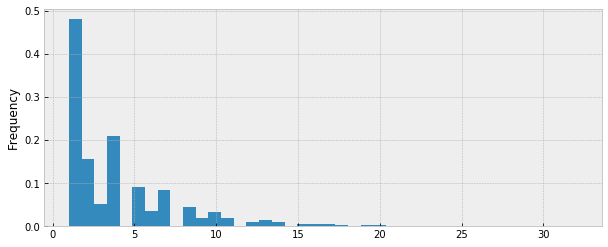

In [7]:
data['Hazard'].plot(kind='hist', figsize=(10, 4), bins=40, normed=True)
plt.show()

В обобщённых линейных моделях, как и в машинном обучении в целом, мы проводим основную работу с апостериорным распределением $p(y|x)$, ведь именно в нём заключается информация о выборке. Здесь же мы знаем, что несчастные случаи во многом подчиняются распределению Пуассона, поэтому будем стараться моделировать именно его.

В выборке могут присутствовать шумовые признаки. Давайте используем простейшим способом избавиться от них.

Исследуйте абсолютное значение корреляции:
* Признаков и отклика
* Признаков и логарифма отклика

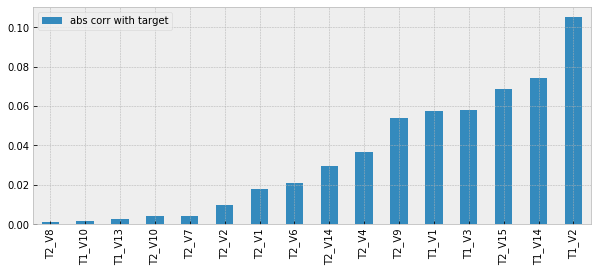

In [8]:
corrs = [data[col].corr(data['Hazard']) for col in numerical]
corrs = pd.DataFrame(np.abs(corrs), numerical, ['abs corr with target']
                    ).sort_values('abs corr with target')
corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

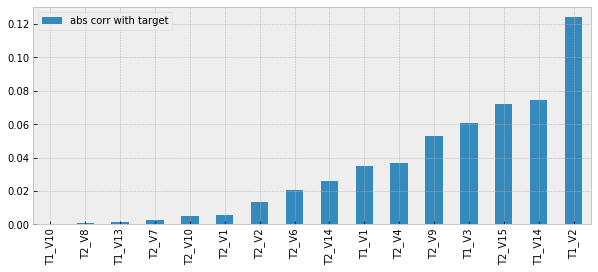

In [9]:
corrs = [data[col].corr(np.log(data['Hazard'])) for col in numerical]
corrs = pd.DataFrame(np.abs(corrs), numerical, ['abs corr with target']
                    ).sort_values('abs corr with target')
corrs.plot(kind='bar', figsize=(10, 4))
plt.show()

Уберите несколько наиболее неинформативных признаков. Лучше сделать это число гиперпараметром и настраивать его по функционалу качества. Регрессия Пуассона соответствует предсказанию логарифма отклика, поэтому разумно исследовать взаимосвязь с именно с ним.

In [10]:
num_least_informative_features = 5
corrs.index[:num_least_informative_features]

Index(['T1_V10', 'T2_V8', 'T1_V13', 'T2_V7', 'T2_V10'], dtype='object')

Закодируем буквы категориальных признаков в числа:

In [11]:
label_encoder = LabelEncoder()
data[categorical] = data[categorical].apply(label_encoder.fit_transform)

Разделим объекты и метки нашей выборки. Область определения счётчиков Пуассона начинается с нуля $\{0, 1, 2...\}$. Поэтому сдвинем наши метки влево на $1$. Это на самом деле приводит к существенному росту качества на валидации. Однако если в конкурсе нужно предсказывать с единицы $\{1, 2, 3...\}$, то потом нужно прибавить единицу.

In [12]:
objects = data.loc[:, 'T1_V1':]
labels = data['Hazard'] - 1

Сделаем бинарное кодирование категориальных признаков:

In [13]:
mask = objects.columns.isin(categorical)
onehot_encoder = OneHotEncoder(categorical_features=mask, sparse=False)
objects_encoded = onehot_encoder.fit_transform(objects)

Разделим выборку на обучающую и контрольную:

In [14]:
train_objects, test_objects, train_labels, test_labels = train_test_split(
    objects_encoded, labels.as_matrix(), random_state=1, test_size=0.2, stratify=labels
)

__Задание 2 (1 балл).__ Обучение регрессии Пуассона.

Реализуйте подсчёт функционала качества и градиентов для нашей линейной модели. Формулы вы можете найти в [конспекте](https://github.com/esokolov/ml-course-msu/blob/master/ML17/lecture-notes/sem20-glm.pdf) по обобщённым линейным моделям или вывести самостоятельно, принимая $$p(y|x, \lambda) = \frac{e^{-\lambda(x)}\lambda(x)^y}{y!}.$$ Численные алгоритмы должны работать по возможности быстро, поэтому циклов быть не должно, и все операции реализуются векторно. Дальше мы будем использовать эту функцию в качестве аргумента другой функции. Можете попробовать добавить в модель регуляризатор.

In [48]:
def oracle(w, X, y):
    """
    :param w: weights
    :param X: features
    :param y: target
    :yield: loss, grad
    """

    reg_coef = 0
    tmp_dot = X.dot(w)
    tmp_exp_dot = np.exp(tmp_dot)
    loss = np.sum(tmp_exp_dot) - tmp_dot.dot(y) + 0.5 * reg_coef * w.dot(w)
    grad = X.T.dot(tmp_exp_dot - y) + reg_coef * w
    return loss, grad

Добавьте к признакам столбец единиц, чтобы учесть вектор сдвига. Это важно. Библиотечные алгоритмы уже учитывают это внутри себя, поэтому им на вход нужно подавать исходную выборку.

In [16]:
train_objects.shape

(40771, 111)

In [55]:
test_objects.shape

(10193, 112)

In [18]:
train_objects = np.hstack((train_objects, np.ones((train_objects.shape[0], 1))))

In [19]:
test_objects = np.hstack((test_objects, np.ones((test_objects.shape[0], 1))))

In [20]:
train_objects_bias = None
test_objects_bias = None

Дальше воспользуйтесь функцией _scipy.optimize.minimize_, в ней реализовано множество методов спуска. Рекоммендуется взять [L-BFGS-B](http://www.machinelearning.ru/wiki/images/6/65/MOMO17_Seminar6.pdf). Начальное приближение весов $x_0$ возьмите из стандартного нормального распределения как _np.random.randn_. Возможно придётся запустить функцию несколько раз, прежде чем начальное приближение окажется удачным, и алгоритм покажет хороший результат. 

Сделайте прогноз для тестовых объектов (не забудьте про экспоненту). Измерьте качество с помощью коэффициента Джини (чем выше – тем лучше).

In [21]:
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred/G_true

In [62]:
w0 = np.random.randn(test_objects.shape[1])

In [63]:
poisson_results = minimize(oracle, x0=w0, args=(train_objects, train_labels), method='L-BFGS-B', jac=True)
pred_labels = np.exp(test_objects.dot(poisson_results.x))
gini(test_labels, pred_labels)

0.31632200374674085

__Задание 3 (1 балл).__ Линейные модели из коробки.

Запустите базовую линейную регрессию *sklearn.linear_model.LinearRegression* и измерьте качество. Сравните полученный результат с работой вашего алгоритма.

In [25]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(train_objects, train_labels)
pred_labels = linreg.predict(test_objects)
gini(test_labels, pred_labels)

0.31397939210786113

Мой алгоритм чуть-чуть лучше

Здесь мы познакомимся с новой библиотекой [StatsModels](http://www.statsmodels.org/dev/index.html). Она предназначена скорее для описательной статистики, проверки гипотез и построения доверительных интервалов, чем для прогнозирования — в отличие от scikit-learn, который создан специально для решения задач машинного обучения. Единственное, в StatsModels реализован очень сильный алгоритм прогнозирования временных рядов – [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html), который при правильной настройке работает очень хорошо и занимает первые места в конкурсах ([Запись трансляции ML тренировки 03.02.18 | TrainMyData Ascott](https://www.youtube.com/watch?v=9MQEEyYDCQc&t=1101s)). 

Мы же попробуем запустить обобщённые линейные модели с различными вероятностными распределениями [GLM](http://www.statsmodels.org/dev/glm.html). Запустите алгоритм _sm.GLM_ на нескольких распределениях family, посмотрите на качество и проинтерпретируйте результаты. Синтаксис StatsModels немного отличается от scikit-learn тем, что здесь объекты и метки задаются в конструкторе модели, метод _fit()_ идёт без аргументов, и после обучения сохраняется новая модель с результатами и методом _predict_. Должно быть не сложно.

__Gaussian__

In [79]:
gaussian_sm_model = sm.GLM(train_labels[:, np.newaxis], train_objects, family=sm.families.Gaussian())
gaussian_sm_results = gaussian_sm_model.fit()
pred_labels = gaussian_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.3137353368774947

__Poisson__

In [80]:
poisson_sm_model = sm.GLM(train_labels[:, np.newaxis], train_objects, family=sm.families.Poisson())
poisson_sm_results = poisson_sm_model.fit()
pred_labels = poisson_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.31630408403586757

__NegativeBinomial (Pascal)__

In [82]:
pascal_sm_model = sm.GLM(train_labels[:, np.newaxis], train_objects, family=sm.families.NegativeBinomial())
pascal_sm_results = pascal_sm_model.fit()
pred_labels = pascal_sm_results.predict(test_objects)
gini(test_labels, pred_labels)

0.3171597374667397

Ага, качество в последнем случае получилось лучше. На практике чаще используют именно отрицательное Биномиальное распределение. Оно является обобщение геометрического распределения и даёт некоторую свободу в выборе среднего и дисперсии для $p(y|x)$, тогда как в распределении Пуассона среднее и дисперсия совпадают. Если вам будет интересно, можете прочитать подробнее на вики [NegativeBinomial](https://en.m.wikipedia.org/wiki/Negative_binomial_distribution).

__Задание 4. (1 балл)__ Прогнозирование с помощью бустинга.

Что бы мы ни делали, бустинги по-прежнему остаются самыми лучшими алгоритмами прогнозирования для широкого спектра задач. В особенности, если мы не работаем со структурированными данными: последовательностями или картинками. Бустинг хоть и сложный по своей структуре алгоритм, но вероятностные распределения не чужды и ему. Запустите _LGBMModel_ используя классическую регрессию и регрессию Пуассона. Настройте параметры, чтобы добиться наилучшего качества. В особенности обратите внимание на *objective*, *n_estimators*, *num_leaves* и *colsample_bytree*.

In [86]:
lgbm = LGBMModel(objective='regression', n_estimators=100, num_leaves=31, colsample_bytree=1)
lgbm.fit(train_objects, train_labels)
pred_labels = lgbm.predict(test_objects)
gini(test_labels, pred_labels)

0.35948998481143674

In [85]:
lgbm = LGBMModel(objective='poisson', n_estimators=100, num_leaves=31, colsample_bytree=1)
lgbm.fit(train_objects, train_labels)
pred_labels = lgbm.predict(test_objects)
gini(test_labels, pred_labels)

0.36652933735421006

__Задание 5 (1 балл).__ Выводы.

lgbm с правильно настроенной objectie работает лучше, чем настроенный на регрессию (соответствует нормальному распределению). Тоже самое мы видели, если просто делать линейную регрессию: регрессия Пуассона давала лучший результат. Также написанный мною алгоритм дал такой же результат, как библотечный.

__Задание 7 (0.3 балла).__ Какую последнюю книгу вы прочитали?

Экзамен по алгебре был недавно, так Журавлёв, Флёров, Вялый ...

__Задание 6 (0.2 балла).__ А здесь оставьте фидбек на задание

Классное задание!
Как читаешь, сразу всё понятно -- везде в коде комментарии выставлены, всё подробно разъяснено. Вообще почти все задния по ML у нас были довольно понятными (в одном только kaggle комментариев было мало).